In [1]:
# --- Import additional layers and tools for experimentation ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Bidirectional, Dropout, Input, Layer
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load rolling window sequences (shape: [num_samples, window_size, num_features])
X = np.load("/content/drive/MyDrive/PrognosAI_OCT25/Data/rolling_window_sequences.npy")      # Feature array

# Load metadata that contains engine_id, cycle, RUL, etc.
metadata = pd.read_csv("/content/drive/MyDrive/PrognosAI_OCT25/Data/sequence_metadata_with_RUL.csv")
y = metadata["RUL"].values                     # Target RUL array

# Print shapes to verify
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (152559, 30, 66)
y shape: (152559,)


In [5]:
from sklearn.model_selection import train_test_split
# Split into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)

# Inspect sample batches
print("Sample X_train[0] batch shape:", X_train[0].shape)
print("First 5 RUL targets:", y_train[:5])

Train shape: (122047, 30, 66) (122047,)
Val shape: (30512, 30, 66) (30512,)
Sample X_train[0] batch shape: (30, 66)
First 5 RUL targets: [ 56. 296.  86. 122. 121.]


In [7]:
import tensorflow as tf
# Data Pipeline / Generator (optional, for very large data)
# Keras can accept Numpy arrays directly in fit(), so for most practical cases, we can skip writing a custom generator
# If memory is a concern, use tf.data.Dataset.from_tensor_slices
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).prefetch(1)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64).prefetch(1)

### 1. Deeper Stacked LSTM Model with Dropout and L2 Regularization

A deeper stacked LSTM model consists of multiple LSTM layers placed sequentially, allowing the network to learn complex temporal dependencies and hierarchical features by capturing short-term patterns in lower layers and longer-term ones in higher layers. To improve generalization and reduce overfitting, dropout is applied after each LSTM layer, randomly dropping neurons during training to prevent reliance on any single unit, which is important for deep models with many parameters. Additionally, L2 regularization adds a penalty on the squared magnitude of weights during training, encouraging smaller weights and controlling model complexity, making the combination of stacked LSTM, dropout, and L2 regularization a practical approach to building deep, robust, and expressive models for time-series forecasting tasks.

In [8]:
# Model with 2 stacked LSTM layers, dropout and L2 weight regularization
def build_stacked_lstm_model(input_shape, lstm_units=64, dropout_rate=0.3, l2_reg=1e-4):
    model = Sequential([
        LSTM(lstm_units, activation='tanh', return_sequences=True,
             kernel_regularizer=regularizers.l2(l2_reg),
             input_shape=input_shape),
        Dropout(dropout_rate),
        LSTM(lstm_units, activation='tanh', return_sequences=False,
             kernel_regularizer=regularizers.l2(l2_reg)),
        Dropout(dropout_rate),
        Dense(1)
    ])
    return model

model_stacked = build_stacked_lstm_model(input_shape=(X.shape[1], X.shape[2]))
model_stacked.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model_stacked.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        33,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,625 (260.25 KB)

 Trainable params: 66,625 (260.25 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# Traning Setup: Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1
)
model_ckpt = ModelCheckpoint('best_model.keras', monitor='val_loss', verbose=1
)

In [11]:
# Model Training
history = model_stacked.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr, model_ckpt]
)

Epoch 1/50
1905/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 25489.2832
Epoch 1: saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - loss: 25480.2227 - val_loss: 11657.1152 - learning_rate: 0.0010
Epoch 2/50
1902/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10530.7021
Epoch 2: saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 10528.2012 - val_loss: 7610.0972 - learning_rate: 0.0010
Epoch 3/50
1906/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6454.1416
Epoch 3: saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 6453.1099 - val_loss: 4115.9170 - learning_rate: 0.0010
Epoch 4/50
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4064.4749
Epoch 4: saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 4064.3789 - val_loss: 3341.1318 - learning_rate: 0.0010
Epoch 5/50
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3466.3022
Epoch 5: saving model to best_mod

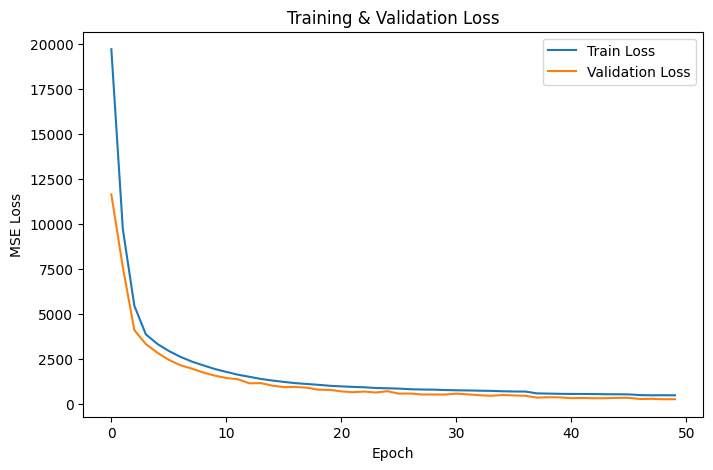

In [13]:
import matplotlib.pyplot as plt
# Training and Validation Curves
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


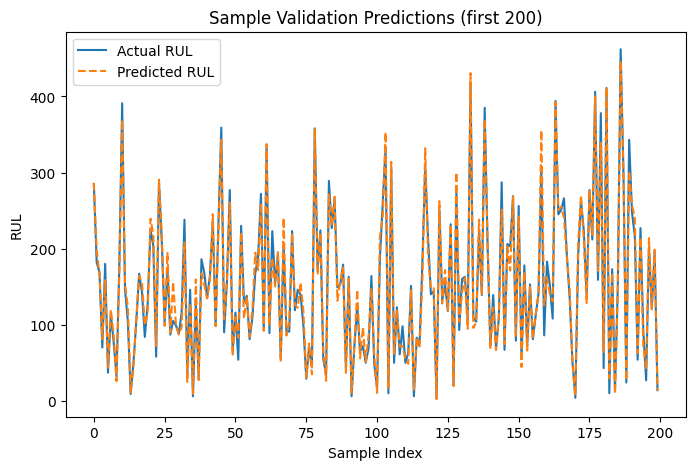

In [15]:
# Verify Model Predictions
val_pred = model_stacked.predict(X_val[:200]).flatten()
plt.figure(figsize=(8,5))
plt.plot(y_val[:200], label='Actual RUL')
plt.plot(val_pred, label='Predicted RUL', linestyle='--')
plt.title('Sample Validation Predictions (first 200)')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()
plt.show()

### 2. Bidirectional LSTM Model

A bidirectional LSTM (BiLSTM) enhances the traditional LSTM by processing input sequences in both forward (past to future) and backward (future to past) directions, enabling the model to access context from both preceding and succeeding time steps. This dual approach provides richer sequence understanding and captures dependencies that unidirectional LSTMs might miss, making BiLSTMs especially valuable in tasks like Remaining Useful Life (RUL) prediction and natural language processing. The outputs from both directions are combined—usually by concatenation or summation—to form a comprehensive representation at each time step. While bidirectional LSTMs improve context awareness and accuracy, they require the entire sequence upfront, leading to increased training time and computational complexity, thus being better suited for offline or batch processing rather than real-time streaming.

In [16]:
# Bidirectional LSTM layer to capture forward and backward temporal dependencies
def build_bidirectional_lstm_model(input_shape, lstm_units=64, dropout_rate=0.3):
    model = Sequential([
        Bidirectional(LSTM(lstm_units, activation='tanh', return_sequences=False),
                      input_shape=input_shape),
        Dropout(dropout_rate),
        Dense(1)
    ])
    return model

model_stacked = build_bidirectional_lstm_model(input_shape=(X.shape[1], X.shape[2]))
model_stacked.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model_stacked.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128)            │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,201 (262.50 KB)

 Trainable params: 67,201 (262.50 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Model Training
history = model_stacked.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr, model_ckpt]
)

Epoch 1/50
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 20378.7480
Epoch 1: saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 20375.4531 - val_loss: 8559.1396 - learning_rate: 0.0010
Epoch 2/50
1906/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6913.9595
Epoch 2: saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 6912.7417 - val_loss: 4300.5649 - learning_rate: 0.0010
Epoch 3/50
1904/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4287.3037
Epoch 3: saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 4286.9819 - val_loss: 3782.6736 - learning_rate: 0.0010
Epoch 4/50
1901/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3829.9136
Epoch 4: saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 3829.6846 - val_loss: 3443.7859 - learning_rate: 0.0010
Epoch 5/50
1905/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3623.9092
Epoch 5: saving model to best_model.ke

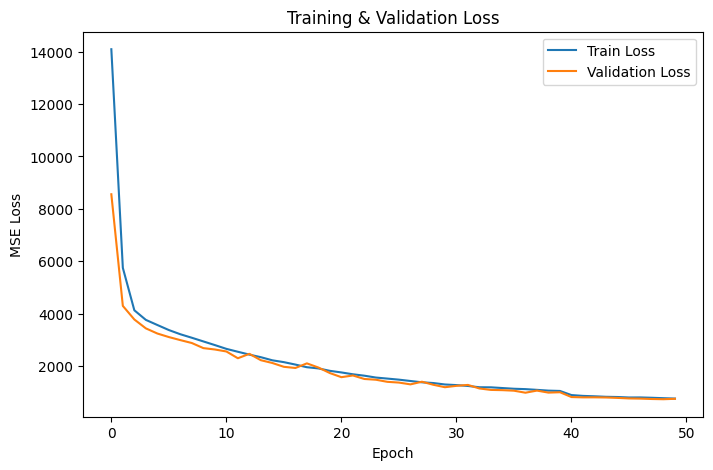

In [18]:
import matplotlib.pyplot as plt
# Training and Validation Curves
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


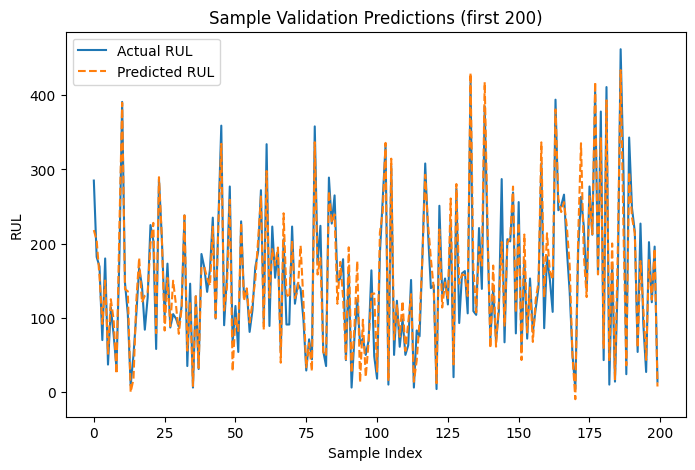

In [19]:
# Verify Model Predictions
val_pred = model_stacked.predict(X_val[:200]).flatten()
plt.figure(figsize=(8,5))
plt.plot(y_val[:200], label='Actual RUL')
plt.plot(val_pred, label='Predicted RUL', linestyle='--')
plt.title('Sample Validation Predictions (first 200)')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()
plt.show()

### 3. Attention Mechanism Layer (Basic Additive Attention)

The attention mechanism enables neural networks to dynamically focus on the most relevant parts of input sequences by computing alignment scores between the current state and each sequence element using learned weights and biases. These scores are normalized via softmax to generate attention weights that highlight important time steps, producing a weighted sum that emphasizes critical temporal information instead of treating all inputs equally. This approach overcomes the limitations of fixed-length summaries in standard RNNs or LSTMs by selectively pooling important features, improving model capacity and accuracy in tasks like language translation and time-series forecasting. Implemented as an attention layer over LSTM hidden states, it assigns importance scores that help the model focus on key sequence parts indicative of outcomes like remaining useful life, while also adding interpretability by allowing visualization of which time frames influenced predictions—making attention highly useful in predictive maintenance and RUL estimation.

In [20]:
# Simple Attention Layer Definition
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

# Model with attention after LSTM
from tensorflow.keras.models import Model

def build_lstm_attention_model(input_shape, lstm_units=64, dropout_rate=0.3):
    inputs = Input(shape=input_shape)
    lstm_out = LSTM(lstm_units, return_sequences=True)(inputs)
    attention_out = Attention()(lstm_out)
    dropout_out = Dropout(dropout_rate)(attention_out)
    outputs = Dense(1)(dropout_out)
    model = Model(inputs=inputs, outputs=outputs)
    return model

model_attention = build_lstm_attention_model(input_shape=(X.shape[1], X.shape[2]))
model_attention.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model_attention.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 30, 66)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 30, 64)         │        33,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 64)             │            94 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,695 (131.62 KB)

 Trainable params: 33,695 (131.62 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Model Training
history = model_stacked.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr, model_ckpt]
)

Epoch 1/50
1904/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 759.8307
Epoch 1: saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 759.8376 - val_loss: 719.5975 - learning_rate: 5.0000e-04
Epoch 2/50
1902/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 763.6292
Epoch 2: saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 763.6025 - val_loss: 776.3119 - learning_rate: 5.0000e-04
Epoch 3/50
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 744.6996
Epoch 3: saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 744.6987 - val_loss: 747.8914 - learning_rate: 5.0000e-04
Epoch 4/50
1903/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 744.7682
Epoch 4: saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 744.7662 - val_loss: 712.8663 - learning_rate: 5.0000e-04
Epoch 5/50
1902/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 723.8524
Epoch 5: saving model to best_model.k

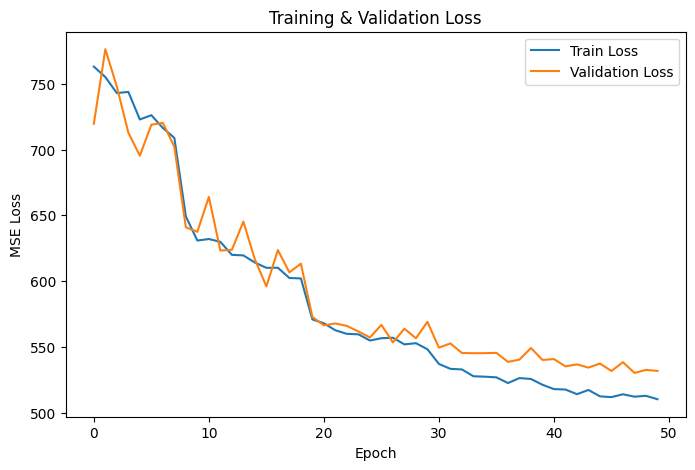

In [22]:
import matplotlib.pyplot as plt
# Training and Validation Curves
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


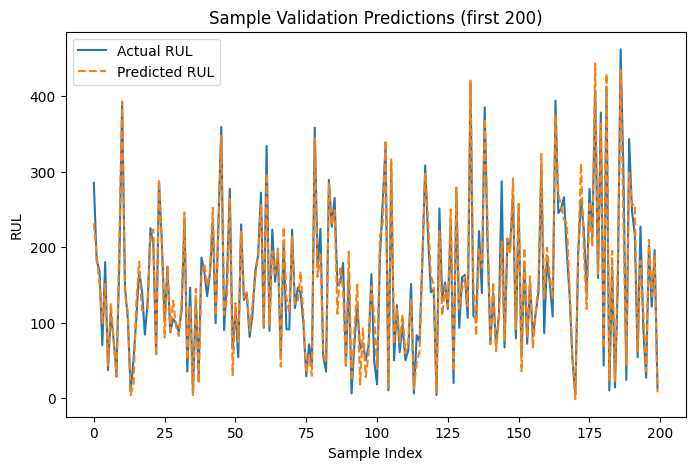

In [23]:
# Verify Model Predictions
val_pred = model_stacked.predict(X_val[:200]).flatten()
plt.figure(figsize=(8,5))
plt.plot(y_val[:200], label='Actual RUL')
plt.plot(val_pred, label='Predicted RUL', linestyle='--')
plt.title('Sample Validation Predictions (first 200)')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()
plt.show()